Cell data type: <class 'numpy.ndarray'>
Image data shape: (1080, 1920, 4)
Data has more than 2 dimensions. Reducing to 2D.


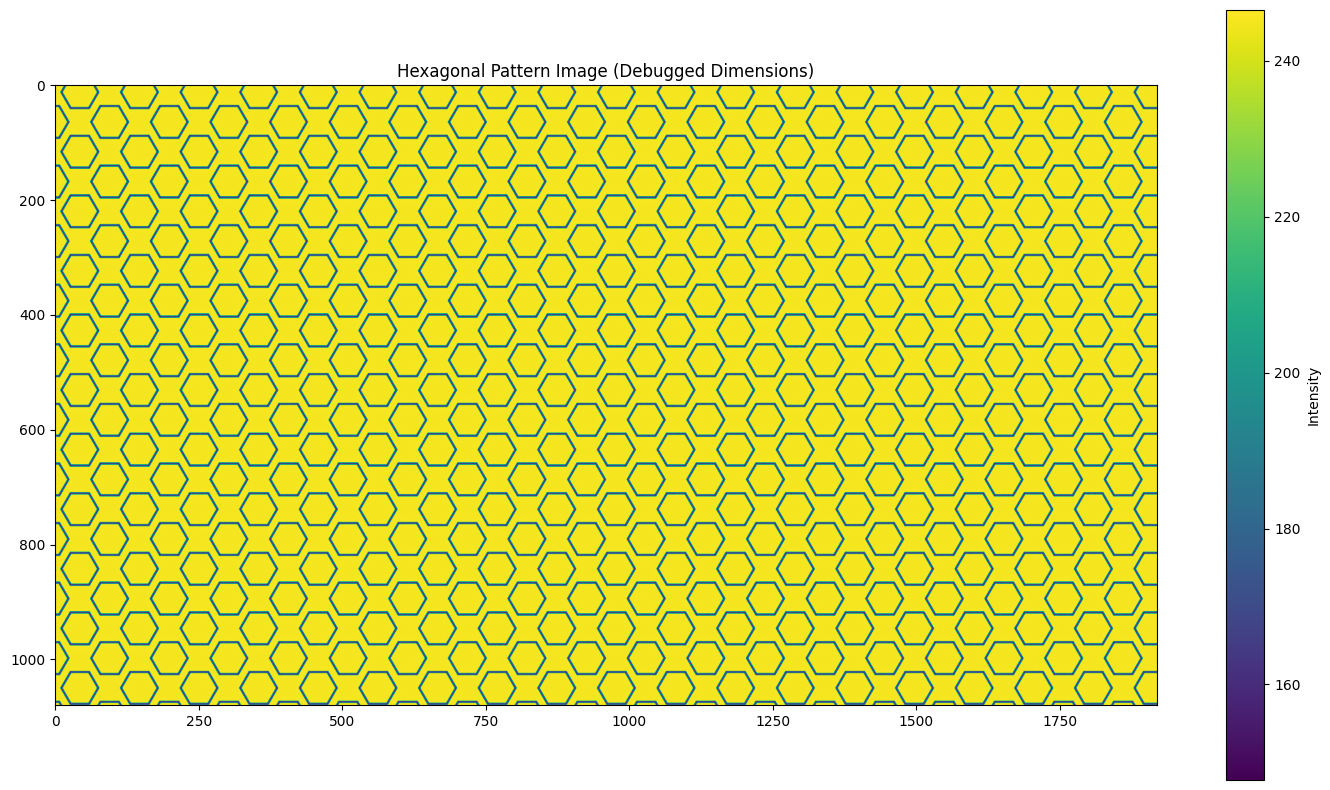

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Path to the pickle file
file_path = 'hex_img_data.pkl'

def custom_load_pickle(file_path):
    """
    Custom wrapper to load the pickle file and handle it as-is.
    """
    try:
        # Load the pickle file
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Ensure it's a DataFrame
        if isinstance(data, pd.DataFrame):
            return data
        else:
            raise ValueError("Loaded data is not a DataFrame.")
    except Exception as e:
        print(f"Error loading pickle data: {e}")
        return pd.DataFrame()  # Return empty DataFrame on failure

try:
    # Load the data
    raw_data = custom_load_pickle(file_path)

    if not raw_data.empty:
        # Extract the single cell
        cell_data = raw_data.iloc[0, 0]  # Access the single cell
        print(f"Cell data type: {type(cell_data)}")

        # If the cell contains an array-like structure, reshape it
        if isinstance(cell_data, np.ndarray):
            image_data = cell_data
        else:
            image_data = np.array(cell_data)

        # Debugging the shape
        print(f"Image data shape: {image_data.shape}")

        # Validate the shape
        if len(image_data.shape) > 2:
            # If more than 2D, reduce dimensions (e.g., take the first layer or average channels)
            print("Data has more than 2 dimensions. Reducing to 2D.")
            image_data = np.mean(image_data, axis=-1)  # Average over the last axis

        if len(image_data.shape) == 1:
            # If 1D, assume square and reshape (if possible)
            side_length = int(np.sqrt(len(image_data)))
            image_data = image_data.reshape((side_length, side_length))

        # Get dimensions for correct aspect ratio
        height, width = image_data.shape
        aspect_ratio = width / height

        # Display the hexagonal image
        plt.figure(figsize=(10 * aspect_ratio, 10))
        plt.imshow(image_data, cmap='viridis', aspect='equal')
        plt.title("Hexagonal Pattern Image (Debugged Dimensions)")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print("The loaded data is empty.")
except Exception as e:
    print(f"An error occurred: {e}")

DataFrame shape: (1, 1)
Image data type: <class 'numpy.ndarray'>


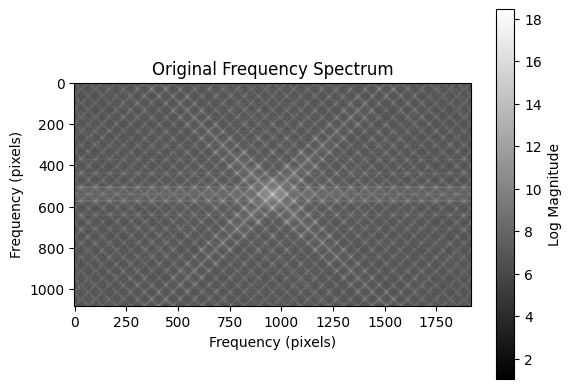

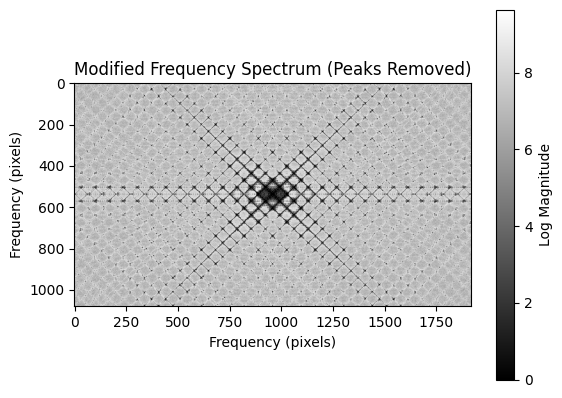

In [6]:
"""
This script loads image data from a pickle file, 
perform Fourier transform (FFT) operations, and modify the frequency spectrum 
by removing periodic components.
"""
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preparation import twod_fft_mag, shift_fft

# Modified load pickle function
def load_pickle_data(pickle_file_path: str, structure_size: tuple = None):
    try:
        if not os.path.isfile(pickle_file_path):
            raise FileNotFoundError(f"The file '{pickle_file_path}' was not found.")
        
        with open(pickle_file_path, 'rb') as f:
            df = pickle.load(f)

        if df.empty:
            raise ValueError("The loaded DataFrame is empty.")

        print(f"DataFrame shape: {df.shape}")

        # Adjust index and columns based on structure size if provided
        if structure_size:
            rows, cols = structure_size
            if rows * cols != df.size:
                raise ValueError("Structure size does not match the DataFrame size.")
            df.index = list(range(rows))
            df.columns = list(range(cols))
        else:
            df.index = list(range(df.shape[0]))
            df.columns = list(range(df.shape[1]))

        return df
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the pickle file
file_path = 'cube_grid_side_data.pkl'
data = load_pickle_data(file_path)

# Extract the image data
image_data = data.iloc[0, 0]
print(f"Image data type: {type(image_data)}")

# Convert the nested list to a numpy array
image_data = np.array(image_data)

# Convert image data to grayscale by averaging the RGB channels
if image_data.ndim == 3 and image_data.shape[2] == 3:
    gray_image = np.mean(image_data, axis=-1)
else:
    gray_image = image_data

# Perform 2D FFT using twod_fft_mag
fft_result = twod_fft_mag(gray_image)

# Shift the zero-frequency component to the center using shift_fft
shifted_fft_result = shift_fft(pd.DataFrame(fft_result))

# Apply periodic_erase to remove periodic peaks
erased_fft_result = periodic_erase(shifted_fft_result)

# Calculate the frequency spectrum before and after erasing
original_magnitude_spectrum = np.abs(shifted_fft_result)
erased_magnitude_spectrum = np.abs(erased_fft_result)

# Plot the original frequency spectrum
plt.imshow(np.log(original_magnitude_spectrum + 1), cmap='gray') # Log spectrum
plt.colorbar(label='Log Magnitude')
plt.title("Original Frequency Spectrum")
plt.xlabel("Frequency (pixels)")
plt.ylabel("Frequency (pixels)")
plt.show()

# Plot the modified frequency spectrum after erasing periodic components
plt.imshow(np.log(erased_magnitude_spectrum + 1), cmap='gray')
plt.colorbar(label='Log Magnitude')
plt.title("Modified Frequency Spectrum (Peaks Removed)")
plt.xlabel("Frequency (pixels)")
plt.ylabel("Frequency (pixels)")
plt.show()

Processing file: cube_grid_side_data.pkl
Cell data type: <class 'numpy.ndarray'>
Image data shape: (1080, 1920, 3)
Data has more than 2 dimensions. Reducing to 2D.


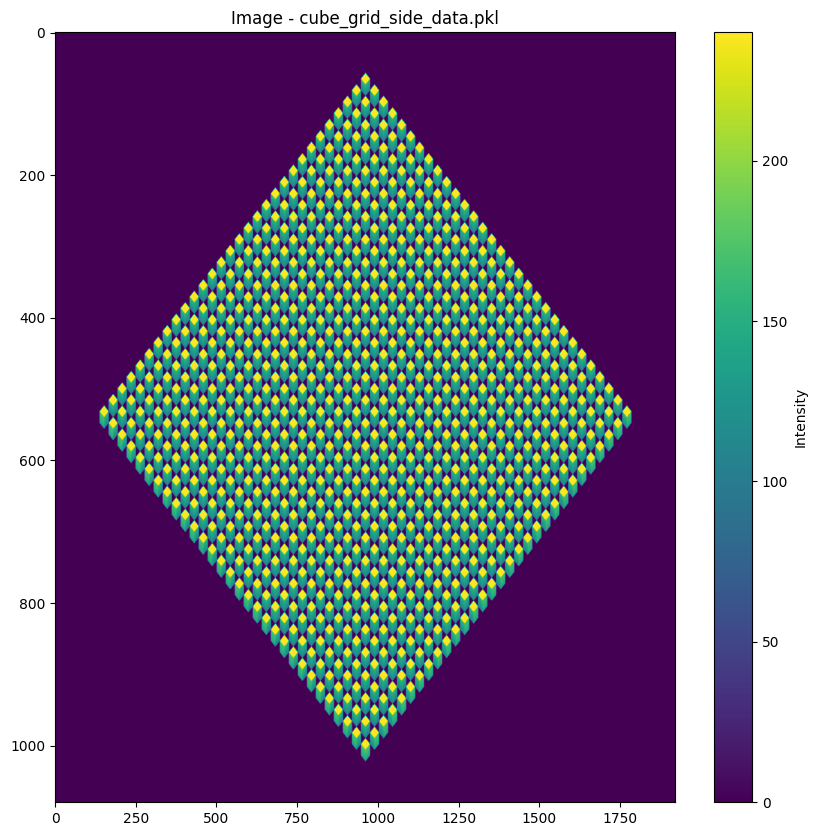

In [7]:
"""
This script processes image data stored in pickle files. It performs various 
transformations, such as Fourier Transforms, periodic peak removal, and data 
visualization. The script is designed to handle common preprocessing tasks 
involving image data stored in tabular (DataFrame) structures.

Modules:
- `os`: For handling file operations.
- `pickle`: For loading and saving serialized data.
- `numpy`: For numerical computations and array manipulations.
- `matplotlib.pyplot`: For visualizing image data.
- `pandas`: For managing tabular data structures.
- `preparation`: Contains custom utility functions such as FFT magnitude computation.

Core Functionalities:
1. Load image data stored in pickle files.
2. Convert image data to 2D format if necessary (e.g., from RGB to grayscale).
3. Perform Fourier Transform operations for frequency analysis.
4. Remove periodic peaks in Fourier-transformed data.
5. Visualize the processed data.

Functions:
- `custom_load_pickle(file_path)`: Safely loads pickle files as DataFrames.
- `averager(values)`: Computes the mean of absolute values in an array.
- `erase(threshold, values)`: Sets values exceeding a threshold in an array to zero.
- `periodic_erase(data)`: Eliminates periodic peaks in Fourier Transform data.
- `load_pickle_data_with_structure(pickle_file_path, structure_size)`: 
  Loads pickle data and optionally adjusts its structure for processing.
"""

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to load a pickle file and ensure it is a DataFrame
def custom_load_pickle(file_path):
    """
    Loads a pickle file and ensures the data is returned as a Pandas DataFrame.

    Parameters:
    - file_path (str): The full path to the pickle file.

    Returns:
    - pd.DataFrame: The loaded data as a DataFrame, or an empty DataFrame if an error occurs.

    Exceptions:
    - FileNotFoundError: Raised if the specified file does not exist.
    - ValueError: Raised if the loaded data is not a DataFrame.
    """
    try:
        # Open and load the pickle file
        with open(file_path, 'rb') as pickle_file:
            loaded_data = pickle.load(pickle_file)
        # Check if the loaded data is a DataFrame
        if isinstance(loaded_data, pd.DataFrame):
            return loaded_data
        raise ValueError("Loaded data is not a DataFrame.")
    except (FileNotFoundError, ValueError) as load_error:
        # Handle errors related to file not found or invalid data format
        print(f"Error loading pickle data: {load_error}")
        return pd.DataFrame()

# Function to compute the average of absolute values
def averager(values):
    """
    Computes the mean of the absolute values in the provided array.

    Parameters:
    - values (np.ndarray): The input array.

    Returns:
    - float: The mean of the absolute values.
    """
    return np.mean(np.abs(values))

# Function to set values above a threshold to zero
def erase(threshold, values):
    """
    Sets all values exceeding a given threshold to zero.

    Parameters:
    - threshold (float): The threshold value above which data is set to zero.
    - values (np.ndarray): The input array.

    Returns:
    - np.ndarray: A modified array with values exceeding the threshold set to zero.
    """
    return np.where(np.abs(values) > threshold, 0, values)

# Function to remove periodic peaks in Fourier transform data

def periodic_erase(data_frame_local):
    """
    Removes periodic peaks from Fourier Transform data by thresholding.

    Parameters:
    - data_frame_local (pd.DataFrame): A DataFrame containing Fourier Transform data.

    Returns:
    - pd.DataFrame: The processed DataFrame with periodic peaks removed.

    Logic:
    - Computes the average magnitude of data values.
    - Sets values exceeding twice the average magnitude to zero.
    """
    # Extract the values from the DataFrame
    values = data_frame_local.values
    # Compute the average magnitude of the values
    avg_magnitude = averager(values)
    # Set values greater than twice the average magnitude to zero
    modified_data = erase(2 * avg_magnitude, values)
    # Return the modified data as a DataFrame
    return pd.DataFrame(modified_data, index=data_frame_local.index,
                        columns=data_frame_local.columns)
# Function to load pickle data and adjust its structure
def load_pickle_data_with_structure(pickle_file_path, structure_size=None):
    """
    Loads data from a pickle file and optionally reshapes it to a specified structure.

    Parameters:
    - pickle_file_path (str): The path to the pickle file.
    - structure_size (tuple, optional): Desired (rows, columns) structure. If None, 
    the data structure is unchanged.

    Returns:
    - pd.DataFrame: The reshaped DataFrame, or an empty DataFrame on failure.

    Exceptions:
    - FileNotFoundError: Raised if the file is not found.
    - ValueError: Raised if the reshaped structure size does not match the data size.
    """
    try:
        # Ensure the file exists
        if not os.path.isfile(pickle_file_path):
            raise FileNotFoundError(f"File '{pickle_file_path}' not found.")
        # Load the pickle file
        with open(pickle_file_path, 'rb') as pickle_file:
            loaded_data = pickle.load(pickle_file)
        # Check if the DataFrame is empty
        if loaded_data.empty:
            raise ValueError("The loaded DataFrame is empty.")

        print(f"DataFrame shape: {loaded_data.shape}")

        # Adjust structure if specified
        if structure_size:
            rows, cols = structure_size
            if rows * cols != loaded_data.size:
                raise ValueError("Structure size does not match DataFrame size.")
            loaded_data.index = list(range(rows))
            loaded_data.columns = list(range(cols))
        else:
            # Default structure adjustment
            loaded_data.index = list(range(loaded_data.shape[0]))
            loaded_data.columns = list(range(loaded_data.shape[1]))

        return loaded_data
    except (FileNotFoundError, ValueError) as load_error:
        # Handle loading errors
        print(f"Error loading data: {load_error}")
        return pd.DataFrame()

# Define the file path
CURRENT_PATH = "cube_grid_side_data.pkl"

# Ensure the file exists
print(f"Processing file: {CURRENT_PATH}")
try:
    # Load data from the pickle file
    raw_data_frame = custom_load_pickle(CURRENT_PATH)

    if not raw_data_frame.empty:
        # Extract data from the first cell of the DataFrame
        cell_data = raw_data_frame.iloc[0, 0]
        print(f"Cell data type: {type(cell_data)}")

        # Convert the cell data to a NumPy array if needed
        image_data = np.array(cell_data) if not isinstance(cell_data, np.ndarray) else cell_data
        print(f"Image data shape: {image_data.shape}")

        # Reduce to 2D if the data has more than 2 dimensions
        if len(image_data.shape) > 2:
            print("Data has more than 2 dimensions. Reducing to 2D.")
            image_data = np.mean(image_data, axis=-1)

        # Plot the image data
        plt.figure(figsize=(10, 10))
        plt.imshow(image_data, cmap='viridis', aspect='auto')
        plt.title(f"Image - {os.path.basename(CURRENT_PATH)}")
        plt.colorbar(label='Intensity')
        plt.show()
    else:
        print(f"The loaded data from {CURRENT_PATH} is empty.")
except (FileNotFoundError, ValueError) as process_error:
    # Handle processing errors
    print(f"An error occurred while processing {CURRENT_PATH}: {process_error}")


DataFrame shape: (1, 1)
Image data type: <class 'numpy.ndarray'>


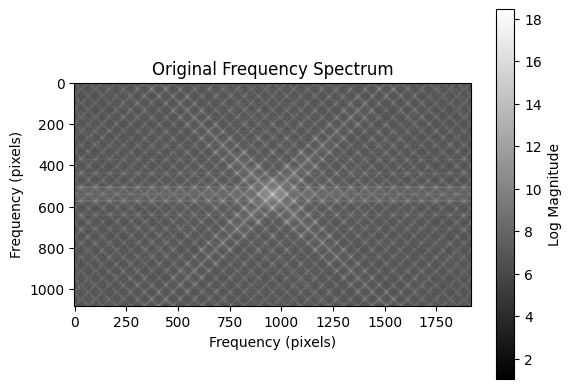

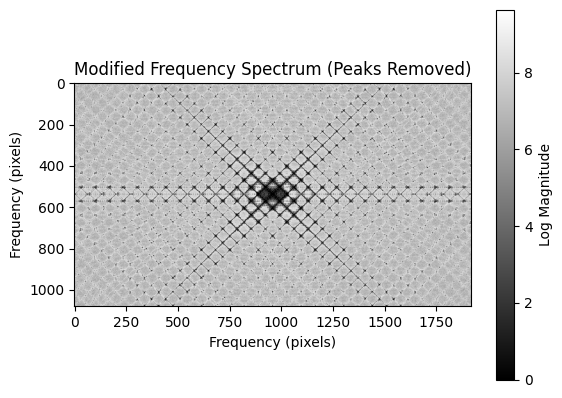

In [1]:
"""
This script loads image data from a pickle file, 
perform Fourier transform (FFT) operations, and modify the frequency spectrum 
by removing periodic components.
"""
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from preparation import twod_fft_mag, shift_fft, periodic_erase

# Modified load pickle function
def load_pickle_data(pickle_file_path: str, structure_size: tuple = None):
    try:
        if not os.path.isfile(pickle_file_path):
            raise FileNotFoundError(f"The file '{pickle_file_path}' was not found.")
        
        with open(pickle_file_path, 'rb') as f:
            df = pickle.load(f)

        if df.empty:
            raise ValueError("The loaded DataFrame is empty.")

        print(f"DataFrame shape: {df.shape}")

        # Adjust index and columns based on structure size if provided
        if structure_size:
            rows, cols = structure_size
            if rows * cols != df.size:
                raise ValueError("Structure size does not match the DataFrame size.")
            df.index = list(range(rows))
            df.columns = list(range(cols))
        else:
            df.index = list(range(df.shape[0]))
            df.columns = list(range(df.shape[1]))

        return df
    except (FileNotFoundError, ValueError, Exception) as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame()

# Load the pickle file
file_path = '/workspaces/CP1-24-HW6/Images/cube_grid_side_data.pkl'
data = load_pickle_data(file_path)

# Extract the image data
image_data = data.iloc[0, 0]
print(f"Image data type: {type(image_data)}")

# Convert the nested list to a numpy array
image_data = np.array(image_data)

# Convert image data to grayscale by averaging the RGB channels
if image_data.ndim == 3 and image_data.shape[2] == 3:
    gray_image = np.mean(image_data, axis=-1)
else:
    gray_image = image_data

# Perform 2D FFT using twod_fft_mag
fft_result = twod_fft_mag(gray_image)

# Shift the zero-frequency component to the center using shift_fft
shifted_fft_result = shift_fft(pd.DataFrame(fft_result))

# Apply periodic_erase to remove periodic peaks
erased_fft_result = periodic_erase(shifted_fft_result)

# Calculate the frequency spectrum before and after erasing
original_magnitude_spectrum = np.abs(shifted_fft_result)
erased_magnitude_spectrum = np.abs(erased_fft_result)

# Plot the original frequency spectrum
plt.imshow(np.log(original_magnitude_spectrum + 1), cmap='gray') # Log spectrum
plt.colorbar(label='Log Magnitude')
plt.title("Original Frequency Spectrum")
plt.xlabel("Frequency (pixels)")
plt.ylabel("Frequency (pixels)")
plt.show()

# Plot the modified frequency spectrum after erasing periodic components
plt.imshow(np.log(erased_magnitude_spectrum + 1), cmap='gray')
plt.colorbar(label='Log Magnitude')
plt.title("Modified Frequency Spectrum (Peaks Removed)")
plt.xlabel("Frequency (pixels)")
plt.ylabel("Frequency (pixels)")
plt.show()

In [ ]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from preparation import load_pickle_data, twod_fft_mag, twod_inv_fft

# Path to the pickle file
file_path = 'cube_grid_top_data.pkl'

def custom_load_pickle(file_path):
    """
    Custom wrapper to load a pickle file containing image data.
    
    This function opens the specified pickle file, loads its content,
    and validates that the content is a pandas DataFrame.
    
    Parameters:
    - file_path (str): Path to the pickle file.
    
    Returns:
    - pd.DataFrame: The loaded DataFrame if successful.
    - pd.DataFrame(): An empty DataFrame in case of failure.
    
    Raises:
    - ValueError: If the loaded data is not a DataFrame.
    """
    try:
        # Open the pickle file
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        # Check if the data is a DataFrame
        if isinstance(data, pd.DataFrame):
            return data
        else:
            raise ValueError("Loaded data is not a DataFrame.")

    except Exception as e:
        # Handle exceptions and return an empty DataFrame on failure
        print(f"Error loading pickle data: {e}")
        return pd.DataFrame()


try:
    # Step 1: Load the pickle file into a pandas DataFrame
    raw_data = custom_load_pickle(file_path)

    if not raw_data.empty:
        """
        Step 2: Extract the image data from the DataFrame.
        
        Assumes that the image data is stored in the first cell of the DataFrame (row 0, column 0).
        Converts the data into a NumPy array for further processing.
        """
        # Extract the single cell containing image data
        cell_data = raw_data.iloc[0, 0]
        print(f"Cell data type: {type(cell_data)}")

        # Convert the extracted cell data to a NumPy array if necessary
        if isinstance(cell_data, np.ndarray):
            image_data = cell_data
        else:
            image_data = np.array(cell_data)

        print(f"Image Shape: {image_data.shape}")
